# Imports

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datacube
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')

# Functions

In [2]:
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    import xarray
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None, src_nodata=None):
    """Blit like"""
    import rasterio
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata,
                                src_nodata=src_nodata)
    return numpy_to_xarray(array, geobox, name)

# Find and inspect one layer

In [3]:
ds = dc.find_datasets(product='s1_gamma0_scene')[3] # grab metadata record concerning an example dataset/layer
ds.center_time # find what time it corresponds to

datetime.datetime(2017, 4, 15, 19, 51, 53, 566905)

This part of the code reads in the data

In [4]:
lon = 145.5895, 146.0649
lat = -17.53, -16.7007
x = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, time=ds.center_time, output_crs='epsg:3577', resolution=(-25,25)) # load that one layer
x

<xarray.Dataset>
Dimensions:  (time: 1, x: 2413, y: 3861)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-15T19:51:53.566905
  * y        (y) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
  * x        (x) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
Data variables:
    vh       (time, y, x) float32 0.0275116 0.0315146 0.0429633 0.0525707 ...
    vv       (time, y, x) float32 0.395897 0.216501 0.150688 0.11122 ...
Attributes:
    crs:      epsg:3577

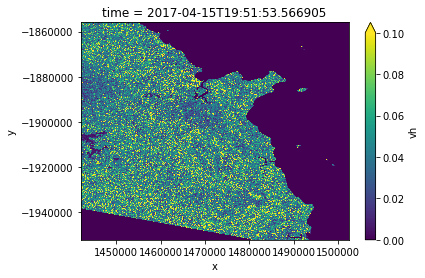

In [5]:
x.vh[:,::2,::2].plot(vmax=0.1)

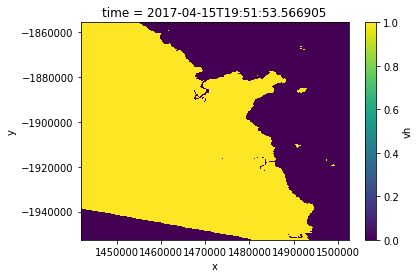

In [6]:
(x.vh != x.vh.nodata)[:,::10,::10].plot()

# (old code) Obtain all layers 
Now revised below to run faster as this code 
Expected to take 5 to 10 minutes: - 

z = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, output_crs='epsg:3577', resolution=(-25,25))

import pickle
with open('/g/data1/w85/sj9724/xarray.pickle', 'wb') as file:
    pickle.dump(z, file, protocol=-1) # write xarray to disk

with open('/g/data1/w85/sj9724/xarray.pickle', 'rb') as file:
    z = pickle.load(file) # this only takes tens of seconds. (~6GB)

# Reset. Clear everything in memory and start again with All Layers

Note this command clears EVERYTHING, so need to reload modules

# Obtain All Layers 

In [7]:
%reset -f

In [8]:
#Imports - 
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datacube
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')

In [9]:
#Define Functions - 
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    import xarray
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None, src_nodata=None):
    """Blit like"""
    import rasterio
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata,
                                src_nodata=src_nodata)
    return numpy_to_xarray(array, geobox, name)

# (new code) .... Revised section - Obtain all Layers

In [10]:
#cache = '/g/data/u46/users/brl654/radar/larry_gradproj/xarray.pickle.2'
#cache = '/g/data1/w85/sj9724/xarray.pickle'
cache = '/g/data/u46/users/sj9724/xarray.pickle.2'
try:
    with open(cache, 'rb') as file:
        z = pickle.load(file) # this only takes tens of seconds. (6GB)
except:
    # this may be 5 to 10 mintues (seeking through half a terabyte)
    z = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, output_crs='epsg:3577', resolution=(-25,25))
    with open(cache, 'wb') as file:
        pickle.dump(z, file, protocol=-1) # save result to disk

# Count observations
Patterns in the observation count often explain flaws in downstream products.

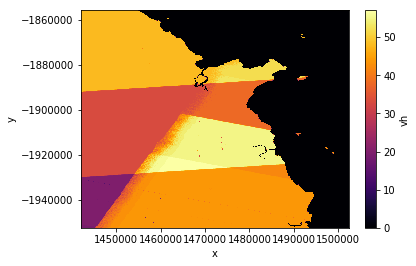

In [11]:

counts = (z.vh!=z.vh.nodata).sum(dim='time')
counts[::4,::4].plot(cmap='inferno')

# Average signal
A naive mean will fail to account for different numbers of observations in different areas.

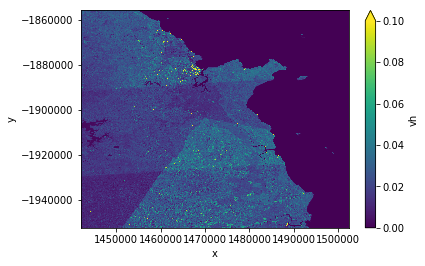

In [12]:
z.vh[:,::4,::4].mean(dim='time').plot(vmax=0.1)

This bit tells me what the 'no data' value is for this dataset

In [13]:
#x.vh.nodata

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


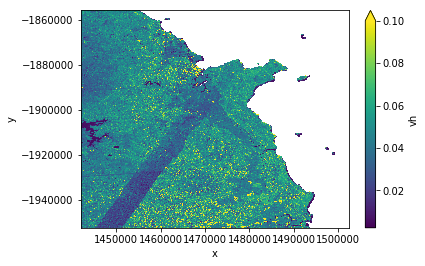

In [14]:
average = (z.vh[:,::4,::4].sum(dim='time') / counts)
average.plot(vmax=0.1)

# Problem 1 - Steps - Identification - Solution

The above image has a strip of "problem" data. 
The following steps were taken to identify the problem -

average[700:800,100:200].plot(vmax=0.1) # Zooming in on a section of the problem area

counts[::4,::4][700:800,100:200].plot() #Looking for all x all y every 4th step

Next -

Looking at the times where nodata - identify layers to zoom into - 

(z.vh!=z.vh.nodata)[:,::4,::4][:,700:800,100:200].sum(dim=['x','y']).plot(marker='o') 

Following 3 steps - analysis and comparison of images to identify 'problem' time steps 1a. Look at last 10 time layers - 5 columns then wrap to next 5 - identify images that show 'bleeding' between areas of data/nodata 1b.Displaying the 'bleeding' time images 2.

(z.vh!=z.vh.nodata)[:,::4,::4][-10:,700:800,100:200].plot(col='time', col_wrap=5) #1a.

(z.vh!=z.vh.nodata)[:,::4,::4][-10:,700:800,100:200].time #1b.show the time of the 'bleeding' images

(z.vh)[:,::4,::4][-10:,700:800,100:200].plot(col='time', col_wrap=5, vmax=0.1)

# Problem 1 - Identified - 
areas where the data is very close to zero but not quite zero

problem = z.sel(time='2017-04-10T19:44:05.949922000').vh[::4,::4].copy()
problem.data[problem.data==0] = np.nan
problem.plot(vmax=0.00001)
(problem < 0.0001).plot() # problem identified - areas where the data is very close to zero but not quite

# Problem 1 - Solution -
We now run the same script that produced the 'problem' image but define where there is data >0.001.  Voilà! Clean image

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive
/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


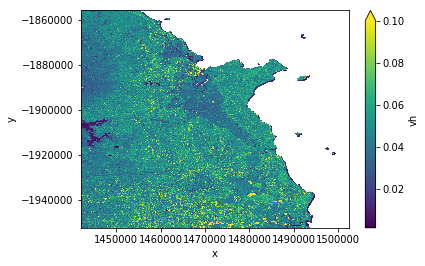

In [15]:
new_counts = (z.vh>0.001).sum(dim='time')
new_average = (z.vh.sum(dim='time') / new_counts)
new_average.plot(vmax=0.1)

In [16]:
# write out the pickled file
with open('/g/data1/w85/sj9724/average_radar', 'wb') as file:
    radar = pickle.dump(new_average, file)

# Clear everything in memory and start over with the created files
Note this command clears EVERYTHING, so need to reload modules

In [1]:
%reset -f

In [2]:
#Imports - 
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datacube
import pandas as pd
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')
import seaborn as sns

In [3]:
#Define Functions - 
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    import xarray
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None, src_nodata=None):
    """Blit like"""
    import rasterio
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata,
                                src_nodata=src_nodata)
    return numpy_to_xarray(array, geobox, name)

In [4]:
#Bring in the averaged radar file to start analysis
import pickle
with open('/g/data1/w85/sj9724/average_radar', 'rb') as file:
    radar = pickle.load(file) 


In [5]:
ds = dc.find_datasets(product='s1_gamma0_scene')[3] # grab metadata record concerning an example dataset/layer
ds.center_time # find what time it corresponds to
lon = 145.5895, 146.0649
lat = -17.53, -16.7007
x = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, time=ds.center_time, output_crs='epsg:3577', resolution=(-25,25)) # load that one layer
mz = rasterfile_to_xarray('/g/data/w85/radar_grad/classify/mz_orig.img', x.geobox, nodata=np.nan, src_nodata=-999.5)
cats = rasterfile_to_xarray('/g/data/w85/radar_grad/classify/terrain.img', x.geobox)

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  


In [6]:
radar

<xarray.DataArray 'vh' (y: 3861, x: 2413)>
array([[ 0.058245,  0.047692,  0.045924, ...,       nan,       nan,       nan],
       [ 0.065239,  0.04173 ,  0.064694, ...,       nan,       nan,       nan],
       [ 0.045139,  0.050599,  0.061313, ...,       nan,       nan,       nan],
       ..., 
       [ 0.058263,  0.050682,  0.035512, ...,       nan,       nan,       nan],
       [ 0.065026,  0.060598,  0.03632 , ...,       nan,       nan,       nan],
       [ 0.049069,  0.054533,  0.044302, ...,       nan,       nan,       nan]])
Coordinates:
  * y        (y) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
  * x        (x) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...

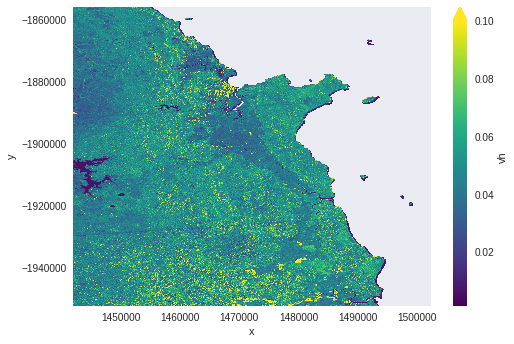

In [7]:
radar.plot(vmax=0.1)

In [8]:
mz

<xarray.DataArray (y: 3861, x: 2413)>
array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       ..., 
       [ 0.959,  0.959,  0.959, ...,  0.973,  0.973,  0.973],
       [ 0.945,  0.959,  0.959, ...,  0.973,  0.973,  0.973],
       [ 0.959,  0.959,  0.959, ...,  0.973,  0.973,  0.973]], dtype=float32)
Coordinates:
  * y        (y) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
  * x        (x) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
Attributes:
    crs:      epsg:3577

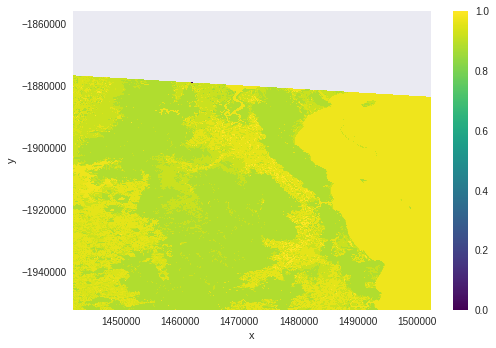

In [9]:
mz.plot()

# Now we want to plot a scatter of radar vs Mz data

In [10]:
# Need to get the radar and cats data into a single list by 'flattening' the data using- 
flatcats = cats.stack(i = ('x','y'))
flatmz = mz.stack(i = ('x','y'))
flatradar = radar.stack(i = ('x','y'))
# Check that they are still looking good
print(flatcats)
print(flatmz) 
print(flatradar)

<xarray.DataArray (i: 9316593)>
array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)
Coordinates:
  * i        (i) MultiIndex
  - x        (i) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
  - y        (i) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
Attributes:
    crs:      epsg:3577
<xarray.DataArray (i: 9316593)>
array([   nan,    nan,    nan, ...,  0.973,  0.973,  0.973], dtype=float32)
Coordinates:
  * i        (i) MultiIndex
  - x        (i) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
  - y        (i) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
Attributes:
    crs:      epsg:3577
<xarray.DataArray 'vh' (i: 9316593)>
array([ 0.058245,  0.065239,  0.045139, ...,       nan,       nan,       nan])
Coordinates:
  * i        (i) MultiIndex
  - x        (i) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
  - y        (i) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...


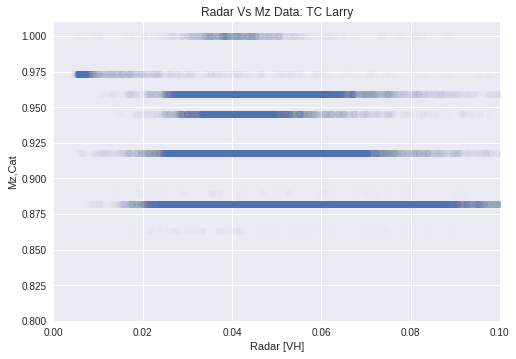

In [30]:
#If they are looking good, we can now do our scatter plot
fig, ax = plt.subplots()
ax.scatter(flatradar[::100], flatmz[::100] , alpha = 0.01)


# We want to limit the xaxis scale to 0-0.10 - xlimit?
ax.set_xlim([0, 0.10])
ax.set_ylim([0.8,1.01])

#Add axes labels (radar and Mzcat)(label categ.)
ax.set_xlabel('Radar [VH]')
ax.set_ylabel('Mz,Cat')
ax.set_title('Radar Vs Mz Data: TC Larry')
plt.show()

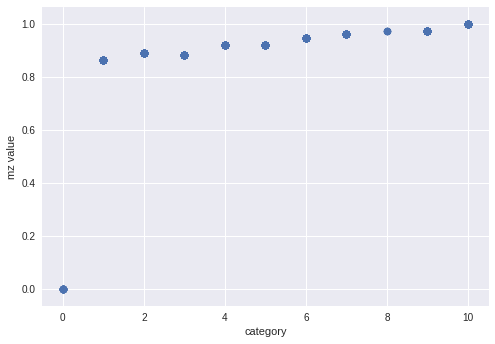

In [12]:
plt.scatter(flatcats.data[::10], flatmz.data[::10])
plt.xlabel('category')
plt.ylabel('mz value')
plt.show()

# Produce histograms of flat data to interrogate results of scatter plot

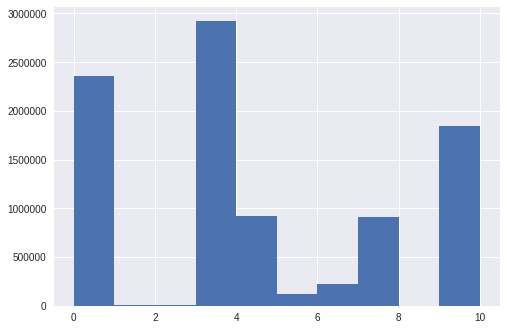

In [13]:
plt.hist(flatcats, 10) # plot flattened categories - flatcat
plt.show()

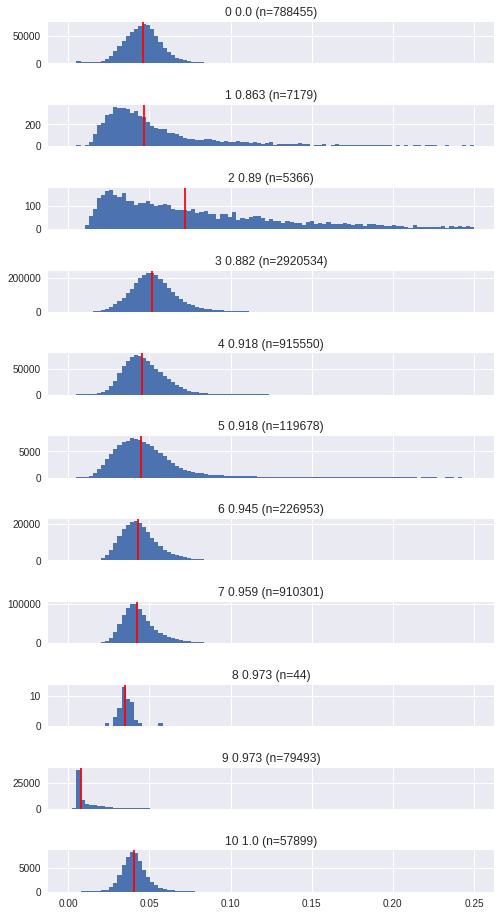

In [33]:
def nanfree(x):
    return x[~np.isnan(x)]
def clean(x):
    return x[np.isfinite(x)]


#plt.hist(subset, bins=np.linspace(0,0.25,100))
#plt.show()

fig, axes = plt.subplots(nrows=11, ncols=1, figsize=(8,16), sharex=True)
axes = axes.ravel()

for i, ax in zip(range(11), axes):
    subset = clean(flatradar.data[flatcats.data == i])
    medi = np.median(subset)
    mz_i = np.unique(clean(flatmz.data[flatcats.data == i])) # find corresponding mz value
    #print(mz_i)
    assert len(mz_i) == 1
    mz_i = mz_i[0]
    
    ax.hist(subset, bins=np.linspace(0,0.25,100))
    ax.axvline(medi, color='r')
    ax.set_title(str(i) + ' ' + str(mz_i) + ' (n=' + str(len(subset)) + ')')


fig.subplots_adjust(hspace=1)
plt.show()

In [22]:
#Remove NaN's and inf from data before plotting histogram of flatmz
#1. Id NaN's

def nanfree(mz):
    return x[~np.isnan(mz)]
def clean(mz):
    return x[np.isfinite(mz)]
#mznan = flatmz.dropna(dim = '?')
#nanlist = np.argwhere(pd.isnull(mznan))
#nanlist
# Identify NaN's in flat mz
mznan = flatmz.dropna(dim = 'i')
nanlist = np.argwhere(pd.isnull(mznan))
nanlist

array([], shape=(0, 1), dtype=int64)

In [25]:
#Remove infinites (inf) from data
mznan.loc[~np.isfinite(mznan)] = np.nan
mznan = mznan.dropna(dim = 'i')

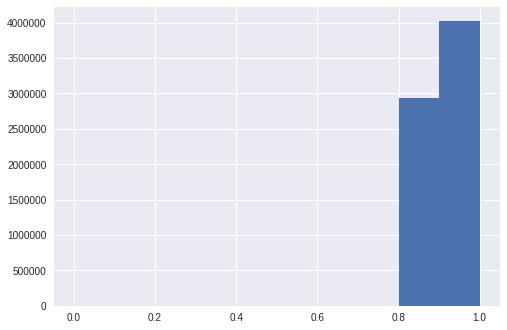

In [27]:
plt.hist(mznan, 10) # plot flattened Mz,cat - flatmz
plt.show()

In [19]:
# Identify NaN's in flat radar
radarnan = flatradar.dropna(dim = 'i')
nanlist = np.argwhere(pd.isnull(radarnan))
nanlist

array([], shape=(0, 1), dtype=int64)

In [34]:
#Remove infinites (inf) from data
radarnan.loc[~np.isfinite(radarnan)] = np.nan
radarnan = radarnan.dropna(dim = 'i')

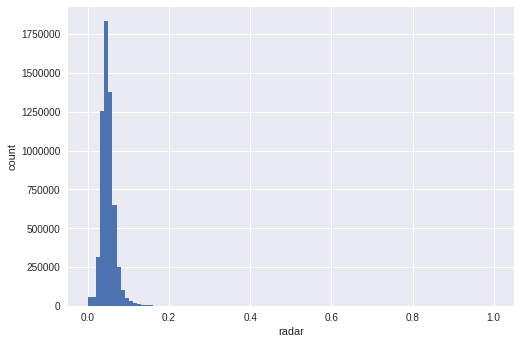

In [35]:
plt.hist(radarnan, bins=np.linspace(0,1,100)) # A histogram of our flat radar data after NaNs are removed.
plt.xlabel('radar')
plt.ylabel('count')
plt.show()

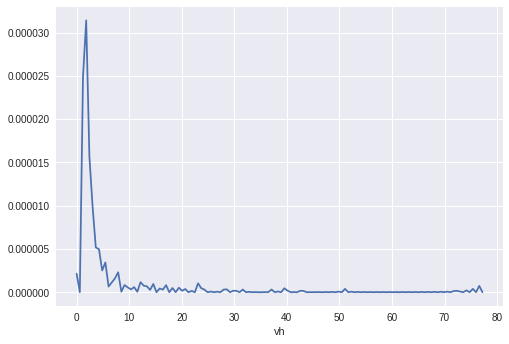

In [36]:
sns.distplot(radarnan, hist=False)